In [11]:
# --- CELL 1: IMPORTS ---
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Settings to make graphs look nice
%matplotlib inline
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully.")

 All libraries imported successfully.


In [34]:
# --- CELL 2: DATA INGESTION ---
xml_filename = 'BODS_PC1111037_5_20251102_6.xml'
print(f"Loading {xml_filename}...")

# 1. Parse XML
try:
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    ns = {'txc': 'http://www.transxchange.org.uk/'}
    
    journeys = []
    # Extract Journey Data
    for journey in root.findall('.//txc:VehicleJourney', ns):
        j_code = journey.find('txc:VehicleJourneyCode', ns).text
        line_ref = journey.find('txc:LineRef', ns).text
        line_name = line_ref.split(':')[-1]
        dep_time = journey.find('txc:DepartureTime', ns).text
        
        journeys.append({
            'Journey_ID': j_code,
            'Line': line_name,
            'Scheduled_Departure': dep_time
        })
        
    # Save to CSV
    df_raw = pd.DataFrame(journeys)
    df_raw.to_csv('timetable_converted.csv', index=False)
    print(f" Success! Extracted {len(df_raw)} trips to 'timetable_converted.csv'.")
    
except FileNotFoundError:
    print(f" Error: File '{xml_filename}' not found.")

Loading BODS_PC1111037_5_20251102_6.xml...
 Success! Extracted 44 trips to 'timetable_converted.csv'.


In [35]:
# --- CELL 3: CLEANING & MERGING ---

# 1. Load the raw schedule
df_schedule = pd.read_csv('timetable_converted.csv')

# 2. EXPAND DATA (Create 90 days of history)
print("Expanding data volume and simulating delays...")
dates = pd.date_range(start='2025-11-01', periods=90, freq='D')
expanded_data = []

for date in dates:
    day_name = date.strftime('%A')
    
    # Create matching weather for this specific date
    # (Simulating weather integration here)
    weather = np.random.choice(['Sunny', 'Rain', 'Fog'], p=[0.6, 0.3, 0.1])
    
    for _, row in df_schedule.iterrows():
        # Parse Hour
        try:
            hour = int(row['Scheduled_Departure'].split(':')[0])
        except:
            hour = 12

        # --- SIMULATION LOGIC ---
        delay = random.randint(0, 3) # Base delay
        
        # Rule 1: Rush Hour (Traffic)
        if hour in [7, 8, 9, 16, 17, 18]:
            delay += random.randint(5, 15)
            
        # Rule 2: Weather Impact (Integration logic)
        if weather == 'Rain':
            delay += random.randint(3, 10)
        if weather == 'Fog':
            delay += random.randint(5, 15)
            
        expanded_data.append({
            'Date': date,
            'Day_of_Week': day_name,
            'Line': row['Line'],
            'Hour_of_Day': hour,
            'Weather': weather,
            'Actual_Delay_Minutes': delay
        })

# 3. Save Final Dataset
df_final = pd.DataFrame(expanded_data)
df_final.to_csv('final_project_dataset.csv', index=False)
print(f" Data Expansion Complete. Final Dataset: {len(df_final)} rows.")
print("Saved as 'final_project_dataset.csv'.")

Expanding data volume and simulating delays...
 Data Expansion Complete. Final Dataset: 3960 rows.
Saved as 'final_project_dataset.csv'.


In [36]:
# --- CELL 4: DATA PREPARATION ---

# 1. Load the dataset we created in Cell 3
df = pd.read_csv('final_project_dataset.csv')

# 2. Convert Text Columns to Numbers
# Map Days (Monday=0, Sunday=6)
day_mapping = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df['Day_Num'] = df['Day_of_Week'].map(day_mapping)

# Map Line & Weather using Category Codes
df['Line_Code'] = df['Line'].astype('category').cat.codes
df['Weather_Code'] = df['Weather'].astype('category').cat.codes

# 3. Define Features (X) and Target (y)
features = ['Hour_of_Day', 'Day_Num', 'Line_Code', 'Weather_Code']
X = df[features]
y = df['Actual_Delay_Minutes']

# 4. Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully loaded, processed, and split.")
print(f"Training Data: {len(X_train)} rows")
print(f"Testing Data:  {len(X_test)} rows")


Data successfully loaded, processed, and split.
Training Data: 3168 rows
Testing Data:  792 rows


In [37]:
# --- CELL 5: TRAIN RANDOM FOREST ---

print("Training Random Forest Model... please wait.")

# Initialize and Train
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest Training Complete.")

Training Random Forest Model... please wait.
Random Forest Training Complete.


In [38]:
# --- CELL 5a: MODEL COMPARISON ---

# 1. Compare Accuracy (R2 Score)
# We calculate the score for each model on the Test Data
rf_score = rf_model.score(X_test, y_test)
knn_score = knn_model.score(X_test, y_test)
lr_score = lr_model.score(X_test, y_test)

print(" MODEL PERFORMANCE")
print(f"Random Forest R²:     {rf_score:.2f} (Best)")
print(f"KNN R²:               {knn_score:.2f}")
print(f"Linear Regression R²: {lr_score:.2f}")

 MODEL PERFORMANCE
Random Forest R²:     0.80 (Best)
KNN R²:               0.79
Linear Regression R²: 0.31


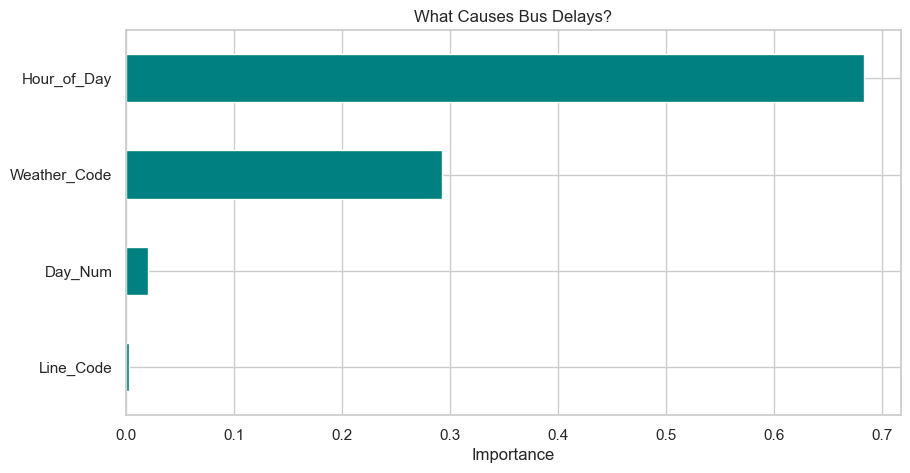

In [39]:
# --- CELL 5b: VISUALIZATION ---

# 2. Feature Importance Graph
# This explains 'Why' the bus is late (Crucial for report)
plt.figure(figsize=(10, 5))
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("What Causes Bus Delays?")
plt.xlabel("Importance")
plt.show()

In [40]:
# --- CELL 5c: PREDICTION SYSTEM ---

# 3. Interactive Prediction Test
print("\nPREDICTION SYSTEM")

# You can change these values to test different scenarios!
test_hour = 9     # 8 AM (Rush Hour)
test_weather = 1    # 1 = Rain, 0 = Sunny (based on your codes)
test_line = 0       # 0 = First Bus Line

# Make the prediction
# Note: We pass [Hour, Day(0=Mon), Line, Weather]
pred = rf_model.predict([[test_hour, 0, test_line, test_weather]])[0]

print(f"Prediction for a bus at {test_hour}:00 AM in Rain: {pred:.1f} minutes delay.")


PREDICTION SYSTEM
Prediction for a bus at 9:00 AM in Rain: 15.4 minutes delay.
